# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [0]:
from fastai.vision import *
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
var textToSave = urls.join('\n');
var hiddenElement = document.createElement('a');
hiddenElement.href = 'data:text/csv;charset=utf-8,' + encodeURI(textToSave);
hiddenElement.target = '_blank';
hiddenElement.download = 'matsumoto.txt';
hiddenElement.click();
```

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [0]:
folder = 'osaka'
file = 'osaka.txt'

In [0]:
folder = 'nagoya'
file = 'nagoya.txt'

In [0]:
folder = 'kumamoto'
file = 'kumamoto.txt'

In [0]:
folder = 'matsumoto'
file = 'matsumoto.txt'

You will need to run this line once per each category.

In [0]:
path = Path('drive/My Drive/data/castles')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

## Download images

Now you will need to download you images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename and the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [0]:
download_images(path/file, dest, max_pics=200)

In [0]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [0]:
classes = ['matsumoto']

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [0]:
data.classes

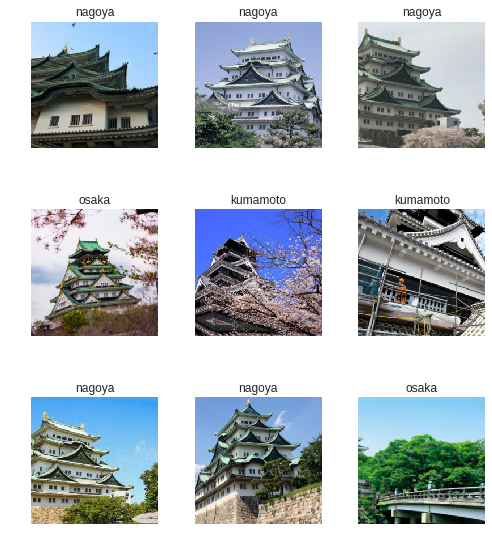

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

## Train model ResNet 34

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

In [0]:
learn.save('stage-1')

## Unfreeze; use learning rate finder; train more

In [0]:
learn.load('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

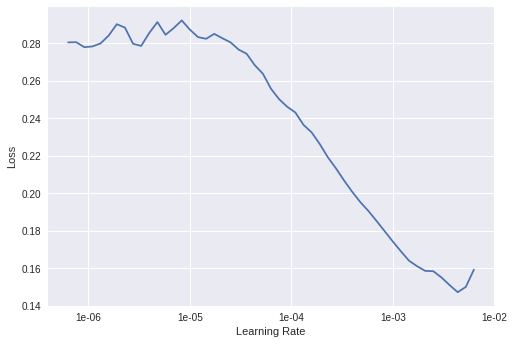

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

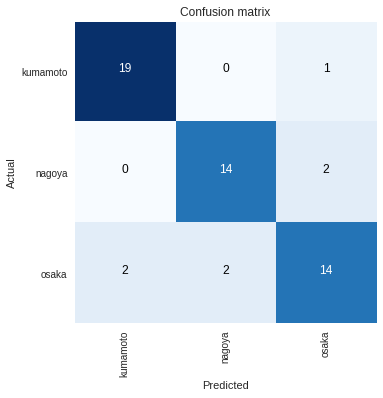

In [0]:
interp.plot_confusion_matrix()

# Results
Let's see what results we have got.

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

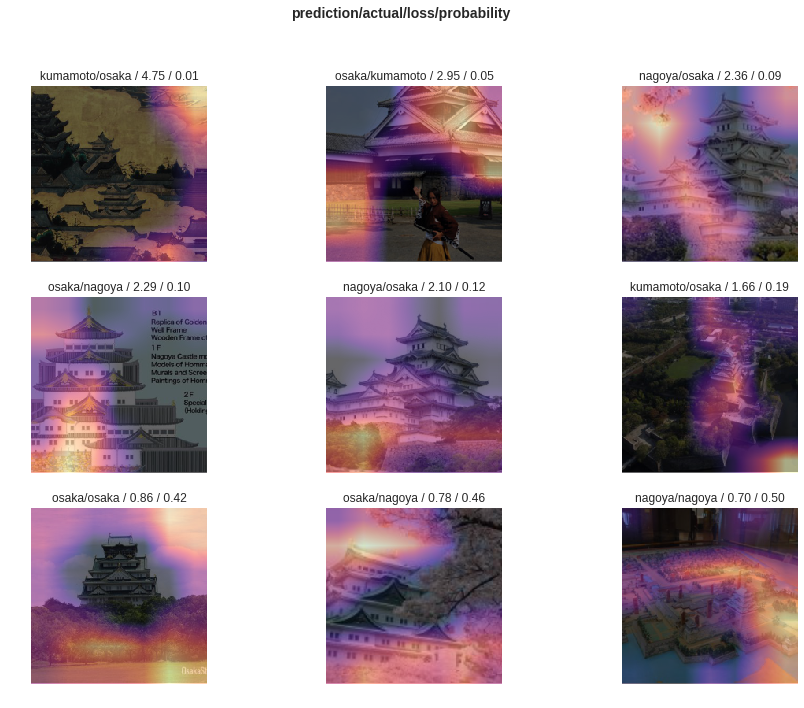

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

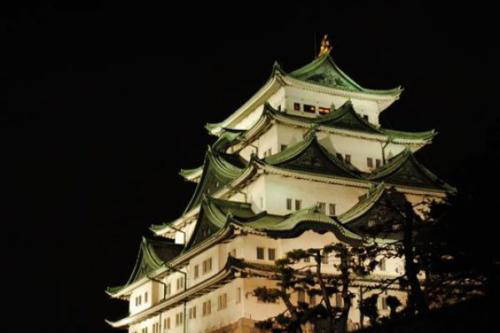

In [0]:
img = open_image(path/'nagoya'/'00000000.jpg')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_idx, outputs

(Category nagoya, tensor(1), tensor([1.5010e-04, 9.9828e-01, 1.5736e-03]))

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)